# Exmaple of Hybrid model trained on Observations 
### Latents gs and scalar $\mu$ for Vcmax and Jmax predicted 
#### Observed tagrets GPP and Transpiration minimzed in loss 

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import easydict
from typing import List, Tuple, Dict, Union, Iterable, Any, Optional
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Function
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer, seed_everything


#### Index each variable with time, site and pft respectively to assign correctly after predicitons 

In [2]:
var_name = "pft" 

class SiteData(Dataset):
    def __init__(self, ds, dtype=np.float32):
        super().__init__()
        
        self.ds = ds.load()
        self.dtype = dtype
        self.coords = np.argwhere(ds.to_array().notnull().all('variable').values)


    def __len__(self):
        return len(self.coords)

    def __getitem__(self, ind):
        time,site,canopy_layer = self.coords[ind]
        d = self.ds.isel(Datetime=time,siteID=site,canopy_layer=canopy_layer)
        return {
            'seb_s_star_box': d['seb_s_star_box'].values.astype(self.dtype),
            'hydro_w_soil_column_box': d['hydro_w_soil_column_box'].values.astype(self.dtype),
            'a2l_co2_air_mol_box': d['a2l_co2_air_mol_box'].values.astype(self.dtype),
            'a2l_q_air_box': d['a2l_q_air_box'].values.astype(self.dtype),
            'a2l_t_air_box': d['a2l_t_air_box'].values.astype(self.dtype),
            'a2l_rain_box': d['a2l_rain_box'].values.astype(self.dtype),
            'a2l_snow_box': d['a2l_snow_box'].values.astype(self.dtype),
            'a2l_wind_air_box': d['a2l_wind_air_box'].values.astype(self.dtype),
            "a2l_press_srf_box": d['a2l_press_srf_box'].values.astype(self.dtype),
            "assimi_dark_respiration_cl_veg": d["assimi_dark_respiration_cl_veg"].values.astype(self.dtype),            
            f"hydro_transpiration_{var_name}" :d[f"hydro_transpiration_{var_name}"].values.astype(self.dtype), 
            f"{var_name}_qsat_surftrans1" : d[f"{var_name}_qsat_surftrans1"].values.astype(self.dtype), 
            f"{var_name}_qsattrans1": d[f"{var_name}_qsattrans1"].values.astype(self.dtype), 
            f"fract_{var_name}": d[f"fract_{var_name}"].values.astype(self.dtype), 
            f"assimi_e_transport_rate_max_cl_{var_name}" :d[f"assimi_e_transport_rate_max_cl_{var_name}"].values.astype(self.dtype),
            f"assimi_e_transport_rate_cl_{var_name}":d[f"assimi_e_transport_rate_cl_{var_name}"].values.astype(self.dtype),
            f"assimi_canopy_cond_cl_{var_name}":d[f"assimi_canopy_cond_cl_{var_name}"].values.astype(self.dtype),
            f"assimi_dark_respiration_cl_{var_name}":d[f"assimi_dark_respiration_cl_{var_name}"].values.astype(self.dtype),
            f"assimi_carbox_rate_max_cl_{var_name}":d[f"assimi_carbox_rate_max_cl_{var_name}"].values.astype(self.dtype),
            f"assimi_carbox_rate_cl_{var_name}":d[f"assimi_carbox_rate_cl_{var_name}"].values.astype(self.dtype),
            f"pheno_fract_fpc_{var_name}": d[f"pheno_fract_fpc_{var_name}"].values.astype(self.dtype),
            f"assimi_canopy_cond_limited_{var_name}" : d[f"assimi_canopy_cond_limited_{var_name}"].values.astype(self.dtype),
            f"assimi_canopy_cond_unlimited_{var_name}" : d[f"assimi_canopy_cond_unlimited_{var_name}"].values.astype(self.dtype),            
            f"{var_name}_qsat_fract" : d[f"{var_name}_qsat_fract"].values.astype(self.dtype),
            'a2l_swpar_srf_down_box' : d['a2l_swpar_srf_down_box'].values.astype(self.dtype),
            'a2l_fract_par_diffuse_box' : d['a2l_fract_par_diffuse_box'].values.astype(self.dtype),
            "canopy_cond_cl_unlim": d['canopy_cond_cl_unlim'].values.astype(self.dtype),
            'T_TEA_NT_conv' : d['T_TEA_NT_conv'].values.astype(self.dtype),
            'T_TEA_NT' : d['T_TEA_NT'].values.astype(self.dtype),
            'GPP_NT' : d['GPP_NT'].values.astype(self.dtype),
            'H_CORR' : d['H_CORR'].values.astype(self.dtype),
            f"rad_lai_cl_{var_name}" : d[f"rad_lai_cl_{var_name}"].values.astype(self.dtype),
            "canopy_cond_cl_unlim": d['canopy_cond_cl_unlim'].values.astype(self.dtype),
            "soil_field_cap" : d["soil_field_cap"].values.astype(self.dtype),
            "soil_porosity" : d["soil_porosity"].values.astype(self.dtype),
            "hyd_cond_sat" : d["hyd_cond_sat"].values.astype(self.dtype),
            "moisture_pot" : d["moisture_pot"].values.astype(self.dtype),
            "wilting_point": d["wilting_point"].values.astype(self.dtype),
            "pore_size_index": d["pore_size_index"].values.astype(self.dtype),
            "assimi_gross_assimilation_ca": d["assimi_gross_assimilation_ca"].values.astype(self.dtype),
            f"pheno_lai_{var_name}": d[f"pheno_lai_{var_name}"].values.astype(self.dtype),
            f"turb_int_mask_{var_name}": d[f"turb_int_mask_{var_name}"].values.astype(self.dtype),
            "a2l_q_air_box_t1": d["a2l_q_air_box_t1"].values.astype(self.dtype),
            "mult": d["mult"].values.astype(self.dtype),
        
            f"rad_apar_per_lai_cl_{var_name}":d[f"rad_apar_per_lai_cl_{var_name}"].values.astype(self.dtype), 
            f"rad_sw_srf_net_{var_name}":d[f"rad_sw_srf_net_{var_name}"].values.astype(self.dtype), 
            'rad_sw_srf_net_box': d['rad_sw_srf_net_box'].values.astype(self.dtype), 
            'precip_box': d['precip_box'].values.astype(self.dtype),                  
            'rad_apar_per_lai_cl_box': d['rad_apar_per_lai_cl_box'].values.astype(self.dtype), 
            "hydro_transpiration_box":d['hydro_transpiration_box'].values.astype(self.dtype),
            "assimi_gross_assimilation_cl_veg":d['assimi_gross_assimilation_cl_veg'].values.astype(self.dtype),
            "seb_sensible_hflx_box":d['seb_sensible_hflx_box'].values.astype(self.dtype),
            "assimi_Co2_conc_leaf_cl_veg":d['assimi_Co2_conc_leaf_cl_veg'].values.astype(self.dtype),
            f"assimi_Co2_conc_leaf_cl_{var_name}":d[f"assimi_Co2_conc_leaf_cl_{var_name}"].values.astype(self.dtype),
            "ga_JSB":d['ga_JSB'].values.astype(self.dtype),
            "a2l_drag_srf_box":d['a2l_drag_srf_box'].values.astype(self.dtype),                                    
            "assimi_carbox_rate_cl_veg":d['assimi_carbox_rate_cl_veg'].values.astype(self.dtype),
            "assimi_e_transport_rate_cl_veg":d['assimi_e_transport_rate_cl_veg'].values.astype(self.dtype),
            'assimi_carbox_rate_max_cl_veg': d['assimi_carbox_rate_max_cl_veg'].values.astype(self.dtype),
           f"assimi_gross_assimilation_cl_{var_name}": d[f"assimi_gross_assimilation_cl_{var_name}"].values.astype(self.dtype),
            'assimi_e_transport_rate_max_cl_veg': d['assimi_e_transport_rate_max_cl_veg'].values.astype(self.dtype),
            'assimi_canopy_cond_limited_veg': d['assimi_canopy_cond_limited_veg'].values.astype(self.dtype),
            'hydro_fract_snow_box': d['hydro_fract_snow_box'].values.astype(self.dtype),
            'hydro_fract_water_box': d['hydro_fract_water_box'].values.astype(self.dtype),
            'a2l_pch_box': d['a2l_pch_box'].values.astype(self.dtype),
            'pheno_fract_fpc_box': d['pheno_fract_fpc_box'].values.astype(self.dtype),
            'seb_qsat_star_box': d['seb_qsat_star_box'].values.astype(self.dtype),
            'a2l_t_acoef_box': d['a2l_t_acoef_box'].values.astype(self.dtype),
            'a2l_t_bcoef_box': d['a2l_t_bcoef_box'].values.astype(self.dtype),
            "a2l_wind_10m_box":d['a2l_wind_10m_box'].values.astype(self.dtype),
            'time_idx': time,
            'site_idx':site,
            'canopy_idx':canopy_layer


        }


### Normalization Module ###

In [3]:
class Normalize(object):
    def __init__(self, dtype: type = np.float32) -> None:
        """Data normalization functionality for torch.Tensor and np.ndarrays.

        Usage:
            1. Create a new instance `Noramlize()`.
            2. Register variables. This means, a variable name and data is passed and the
               mean and standard deviation is recorded.
            3. Pass variable (single or multiple ones) to (un-)normalize them using the
               stats that were regitered before.

        Example:
            Register variables:

            >>> n = Normalize()
            >>> n.register('var_a', torch.arange(10))
            >>> n.register('var_b', np.random.normal(loc=2, scale=10., size=10))
            >>> print(n)
            Normalize(dtype=float32)
            ----------------------------------------
             * var_a: 49.500 (28.866 std)
             * var_b: -0.048 (9.808 std)

            Register variables (pass dict):

            >>> n = Normalize()
            >>> n.register_dict({'var_a': torch.arange(10), 'var_b': np.random.normal(loc=2, scale=10., size=10)})
            >>> print(n)
            Normalize(dtype=float32)
            ----------------------------------------
             * var_a: 4.500 (2.872 std)
             * var_b: -1.733 (12.913 std)

            Normalize data:

            >>> n.normalize('var_a', np.arange(10)).std()
            1.000000003595229

            Denormalize data:

            >>> # A standard normal distributed torch.Tensor is denormalized.
            >>> n.denormalize('var_b', torch.randn(100)).std()
            10.12

            Normalize dict:

            >>> n.normalize_dict({'var_a': torch.arange(2), 'var_b': np.random.normal(loc=2, scale=10., size=2)})
            {'var_a': tensor([-1.5667, -1.2185]),
             'var_b': array([-1.35922953, -0.81025503])}

            Normalize dict and stack (note that we cannot mix np.ndarrays and torch.Tensors here):

            >>> n.normalize_dict(
            ...     {'var_a': np.arange(2),
            ...      'var_b': np.random.normal(loc=2, scale=10., size=2)}, return_stack=True)
            array([[-1.56669891,  0.0801657 ],
                   [-1.2185436 , -0.56352366]])

            Register stats manually:

            n.register_manually('my_var', mean=1.0, std=2.5)

        """
        self._stats = {}
        self.dtype = dtype

    def normalize(
            self,
            key: str,
            x: Union[np.ndarray, torch.Tensor]) -> Union[np.ndarray, torch.Tensor]:
        """Normalize `x`, stats for `key` must have been registered previously.

        Normlization: (x - mean) / std

        Args:
            key (str):
                The name of the variable to normlize.
            x (np.ndarray or torch.Tensor):
                The data to normalize.
        Returns:
            Union[np.ndarray, torch.Tensor]: normalized data, same type as input.
        """
        return self._transform(key, x, invert=False)

    def denormalize(
            self,
            key: str,
            x: Union[np.ndarray, torch.Tensor]) -> Union[np.ndarray, torch.Tensor]:
        """Un-normalize `x`, stats for `key` must have been registered previously.

        Un-normlization: x * std + mean

        Args:
            key (str):
                The name of the variable to un-normlize.
            x (np.ndarray or torch.Tensor):
                The data to un-normalize.

        Returns:
            np.ndarray or torch.Tensor: un-normalized data, same type as input.
        """
        return self._transform(key, x, invert=True)

    def normalize_dict(
            self,
            d: Dict[str, Union[np.ndarray, torch.Tensor]],
            variables: Optional[List[str]] = None,
            return_stack: bool = False) -> Union[Dict[str, Union[np.ndarray, torch.Tensor]], np.ndarray, torch.Tensor]:
        """Normalize data in `d`, stats for keys must have been registered previously.

        Normlization: (x - mean) / std

        Args:
            d (dict):
                The name of the variable to normlize.
            variables (Optional[List[str]]):
                Optional subset of variables to return. All variables must be present in `stats`.
            return_stack (bool):
                Whether to return a stack of all values in `d`. If `False`, a dict with the normalized
                data is returned. If `True`, the values are stacked along the last dimension. The values
                can be troch.Tensors or np.ndarrays. Defaults to `False`.

        Returns:
            dict, np.ndarray, torch.Tensor: normalized data, same type as input. If `return_stack`
                is `True`, a np.ndarray or torch.Tensor is returned.
        """
        self._assert_dtype('d', d, dict)
        self._assert_dtype('return_stack', return_stack, bool)

        if variables is not None:
            self._assert_dtype('variables', variables, list)
            d = {v: d[v] for v in variables}

        d = self._transform_dict(d, invert=False)

        if return_stack:
            return self._stack_dict(d)
        else:
            return d

    def denormalize_dict(
            self,
            d: Dict[str, Union[np.ndarray, torch.Tensor]],
            variables: Optional[List[str]] = None,
            return_stack: bool = False) -> Union[Dict[str, Union[np.ndarray, torch.Tensor]], np.ndarray, torch.Tensor]:
        """Un-normalize data in `d`, stats for keys must have been registered previously.

        Un-normlization: x * std + mean

        Args:
            d (dict):
                The name of the variable to un-normlize.
            variables (Optional[List[str]]):
                Optional subset of variables to return. All variables must be present in `stats`.
            return_stack (bool):
                Whether to return a stack of all values in `d`. If `False`, a dict with the un-normalized
                data is returned. If `True`, the values are stacked along the last dimension. The values
                can be troch.Tensors or np.ndarrays. Defaults to `False`.

        Returns:
            dict, np.ndarray, torch.Tensor: un-normalized data, same type as input. If `return_stack`
                is `True`, a np.ndarray or torch.Tensor is returned.
        """
        self._assert_dtype('d', d, dict)
        self._assert_dtype('return_stack', return_stack, bool)

        if variables is not None:
            self._assert_dtype('variables', variables, list)
            d = {v: d[v] for v in variables}

        d = self._transform_xr(d, invert=True)
        if return_stack:
            return self._stack_dict(d)
        else:
            return d

    def normalize_xr(
            self,
            ds: xr.Dataset,
            variables: Optional[List[str]] = None,
            return_stack: bool = False) -> Union[Dict[str, Union[xr.Dataset, np.ndarray]]]:
        """Normalize an xr.Dataset, stats for keys must have been registered previously.

        Normlization: (x - mean) / std

        Args:
            ds (xr.Dataset):
                The name of the variable to normlize.
            variables (Optional[List[str]]):
                Optional subset of variables to return. All variables must be present in `stats`.
            return_stack (bool):
                Whether to return a np.ndarray stack of all variables. If `False`, an xr.Dataset with the normalized
                data is returned. If `True`, the values are stacked along the last dimension. Defaults to `False`.

        Returns:
            xr.Dataset, np.ndarray: normalized xr.Dataset. If `return_stack` is `True`, a np.ndarray is returned.
        """
        self._assert_dtype('ds', ds, xr.Dataset)
        self._assert_dtype('return_stack', return_stack, bool)

        if variables is not None:
            if isinstance(variables, str):
                variables = [variables]
            self._assert_dtype('variables', variables, list)
            ds = ds[variables]

        ds = self._transform_xr(ds, invert=False)

        if return_stack:
            return ds.to_array().transpose(..., 'variable').values
        else:
            return ds

    def denormalize_xr(
            self,
            ds: xr.Dataset,
            variables: Optional[List[str]] = None,
            return_stack: bool = False) -> Union[Dict[str, Union[xr.Dataset, np.ndarray]]]:
        """Denormalize an xr.Dataset, stats for keys must have been registered previously.

        Unnormlization: (x - mean) / std
        Args:
            ds (xr.Dataset):
                The name of the variable to normlize.
            variables (Optional[List[str]]):
                Optional subset of variables to return. All variables must be present in `stats`.
            return_stack (bool):
                Whether to return a np.ndarray stack of all variables. If `False`, an xr.Dataset with the normalized
                data is returned. If `True`, the values are stacked along the last dimension. Defaults to `False`.

        Returns:
            xr.Dataset, np.ndarray: normalized xr.Dataset. If `return_stack` is `True`, a np.ndarray is returned.
        """
        self._assert_dtype('ds', ds, xr.Dataset)
        self._assert_dtype('return_stack', return_stack, bool)

        if variables is not None:
            if isinstance(variables, str):
                variables = [variables]
            self._assert_dtype('variables', variables, list)
            ds = ds[variables]

        ds = self._transform_xr(ds, invert=True)

        if return_stack:
            return ds.to_array().transpose(..., 'variable').values
        else:
            return ds

    def register(self, key: str, x: Union[np.ndarray, torch.Tensor]) -> None:
        """Register data stats (mean and standard deviation).

        Args:
            key (str):
                The name of the variable.
            x (np.ndarray or torch.Tensor):
                The data to calculate mean and standard deviation from.

        """
        self._assert_dtype('key', key, str)
        self._assert_dtype('x', x, (np.ndarray, torch.Tensor, xr.DataArray))

        mean, std = self._get_mean_and_std(x)
        self._stats.update({key: {'mean': mean, 'std': std}})

    def register_manually(self, key: str, mean: Any, std: Any) -> None:
        """Register data stats (mean and standard deviation) manually.

        Args:
            key (str):
                The name of the variable.
            mean (numeric):
                The mean. Must be castable to `self.dtype`.
            std (numeric):
                The standard deviation. Must be castable to `self.dtype`.

        """
        self._assert_dtype('key', key, str)
        mean = self._cast_to_dtype('mean', mean)
        std = self._cast_to_dtype('std', std)

        self._stats.update({key: {'mean': mean, 'std': std}})

    def register_xr(self, ds: xr.Dataset, variables: Optional[str] = None, exclude: Optional[list] = None) -> None:
        """Register xarray data stats (mean and standard deviation per variable).

        Args:
        ds (xr.Dataset):
            The dataset to record data stats for.
        variables (Optional[str]):
            Variable names to register stats for. Defaults to `None` for all variables in the dataset.
        exclude (Optional[list]):
            Variable names to exclude from normalization. Defaults to `None`.
        """
        self._assert_dtype('ds', ds, xr.Dataset)
        if isinstance(variables, str):
            variables = [variables]
        self._assert_dtype('variables', variables, (list, type(None)))

        if exclude is None:
            exclude = []

        if variables is None:
            variables = list(ds.data_vars)

        for variable in variables:
            if variable not in exclude:
                self.register(variable, ds[variable])
            else:
                print(f"Skipping normalization for {variable}")

    def register_dict(self, d: Dict[str, Union[np.ndarray, torch.Tensor]]) -> None:
        """Register data stats (mean and standard deviation) for dict elements.

        Args:
            d (dict):
                Stats are registered for every key, value pair.

        """
        self._assert_dtype('d', d, dict)

        for key, val in d.items():
            self.register(key, val)

    def deleteitem(self, key: str) -> None:
        """Delet an item from stats.

        key (str):
            The key to delete from the stats.
        """
        self._assert_dtype('key', key, str)

        del self._stats[key]

    def deletelist(self, keys: Iterable[str]) -> None:
        """Delet several items from stats.

        keys (list):
            The keys to delete from the stats.
        """
        if not hasattr(keys, '__iter__'):
            raise TypeError(f'`keys` must be an iterable but is {type(keys)}.')

        for key in keys:
            self.deleteitem(key)

    def save(self, path: str) -> None:
        """Save object to file. Can be restored later using `.load(...)`.

        Args:
            pash (str):
                File path to save object to.
        """
        d_save = self.stats
        d_save.update({'dtype': self.dtype})
        with open(path, 'wb') as f:
            pickle.dump(d_save, f)

    @classmethod
    def load(cls, path: str) -> 'Normalize':
        """Load from file.

        Example:
            >>> n = Normalize()
            >>> n.register_dict({'var_a': torch.arange(10)})
            >>> n.save('test.pkl')
            >>> n_restored = Normalize.load('test.pkl')

        Args:
            path (str):
                File path to save object to.

        Returns:
            Normalize: restored object.
        """
        with open(path, 'rb') as f:
            d = pickle.load(f)
        dtype = d.pop('dtype')
        n = cls(dtype)
        n._set_stats(d)
        return n

    def get_normalization_layer(
        self_,
        variables: Union[List[str], str],
        invert: bool,
        stack: bool) -> torch.nn.Module:
        """Returns a torch data (de-)normalization layer.

        Args:
        variables (List[str] or str):
            Variables to transform, must have been registered previously.
        invert (bool):
            Whether to normalize (`False`) or to invert normalization, i.e., denormalize (`True`).
        stack (bool):
            Whether to stack dict to tensor along last dimension (`True`) or to return
            a dict (`False`). Default is `False`.

        Return:
        torch.nn.Module: a normalization layer.
        """

        self_._assert_dtype('variables', variables, (str, list))
        self_._assert_dtype('invert', invert, bool)
        self_._assert_dtype('stack', stack, bool)

        # Convert to list if a single string is provided
        if isinstance(variables, str):
            variables = [variables]

        # Check for missing stats
        missing = [var for var in variables if var not in self_.stats]
        if missing:
            print(f"Warning: No stats found for keys: {missing}. Skipping normalization for these keys.")

        class DataNorm(torch.nn.Module):
            """Normalization layer for (optionally inverse) standard normal distribution tranfrormation.

            Attributes:
                stats (Dict[str, Dict[str, float]]):
                    Dictionary contining variables (keys), each with `mean`: (float)
                    and `std` (float) stats. Signature: dict(var_a=dict(mean=0.1, std=0.8)).
                variables (List[str]):
                    List of variables to transform, must be present in `stats`.
                invert (bool):
                    If `True`, the transformation is inverted, e.g., de-normalization is done.
                stack (bool):
                    If True, the transformed dict is stacked along last dimension. Else, a dict
                    containing transformed data is returned.

            Args (__call__):
                x: dict[str, Tensor]

            Usage:
                norm_layer = NormLayer('varname', invert=False)
                denorm_layer = NormLayer('varname', invert=True)
                x = dict(varname=torch.randn(10))
                assert torch.isclose(
                        x['varname'],
                        denorm_layer(norm_layer(x))['varname'],
                    )
            """
            def __init__(self) -> None:
                super().__init__()

                self.variables = [variables] if isinstance(variables, str) else variables
                self.invert = invert
                self.stack = stack

                missing = []
                for var in self.variables:
                    if var not in self_.stats:
                        missing.append(var)

                if len(missing) > 0:
                    raise KeyError(f'no stats found for key(s): `{*missing, }`.')

                self._stats = {var: self_.stats[var] for var in self.variables}

            def forward(self, x: Union[torch.Tensor, Dict[str, torch.Tensor]]) -> torch.Tensor:
                """Transform input.

                Args:
                    x (Dict[str: torch.Tensor] or torch.Tensor):
                        - a dict of variable, value pairs. Keys must be present in `stats`, or
                        - a tensor with last dimension matching the number of `variables`. The order
                          is assumed to correspond to `variables`.

                Returns:
                    Either a dict of key, value (torch.Tensor) pairs (if `stack=True`), or a torch.Tensor
                    with variable stacked in last dimension.
                """

                if not isinstance(x, (dict, torch.Tensor)):
                    raise TypeError(
                        f'`x` must be of type `dict` or `torch.Tensor` but is `{type(x).__name__}`.'
                    )

                if isinstance(x, torch.Tensor):
                    x = self._tensor_to_dict(x)

                out = {k: self._normalize(k, x[k]) for k, v in self.stats.items()}

                if self.stack:
                    return torch.stack(list(out.values()), dim=-1)  ### changed from Basil's orginal code from torch.concat to torch.stack
                else:
                    return out

            def _normalize(self, key, val) -> torch.Tensor:
                """Normalize single variable."""

                if key not in self.stats:
                    raise KeyError(f'no stats found for key `{key}`.')

                stats = self.stats[key]
                mn = stats['mean']
                st = stats['std']

                if self.invert:
                    return val * st + mn
                else:
                    return (val - mn) / st

            def _tensor_to_dict(self, x):
                if x.shape[-1] != len(self.variables):
                    raise ValueError(
                        f'`x` last dimension ({x.shape[-1]}) must match number of '
                        f'target variables ({len(self.variables)}).'
                    )

                return {t: x[..., i] for i, t in enumerate(self.variables)}

            @property
            def stats(self) -> Dict:
                """A dict containing means and standard deviations."""
                return self._stats

            def __str__(self) -> str:
                layer_name = 'DataDenorm' if self.invert else 'DataNorm'
                stack = f'stack={self.stack}'
                s = f'{layer_name}(variables=[{", ".join(self.variables)}], {stack})'
                return s

            def __repr__(self) -> str:
                return self.__str__()

        return DataNorm()

    @property
    def stats(self) -> Dict:
        """A dict containing means and standard deviations."""
        return self._stats

    def _transform(
            self, key: str,
            x: Union[np.ndarray, torch.Tensor],
            invert: bool = False) -> Union[np.ndarray, torch.Tensor]:
        """Transform data, either normalize or denormalize (if `invert`)"""
        if key not in self.stats:
            raise KeyError(f'no stats found for key `{key}`.')
        self._assert_dtype('invert', invert, bool)

        stats = self.stats[key]
        m = stats['mean']
        s = stats['std']

        if invert:
            return x * s + m
        else:
            return (x - m) / s

    def _transform_dict(
            self,
            d: Dict[str, Union[np.ndarray, torch.Tensor]],
            invert: bool = False) -> Dict[str, Union[np.ndarray, torch.Tensor]]:
        """Transform data, either normalize or denormalize (if `invert`)"""
        self._assert_dtype('d', d, dict)

        r = {}
        for key, val in d.items():
            r.update({key: self._transform(key, val, invert=invert)})

        return r

    def _transform_xr(
            self,
            ds: xr.Dataset,
            invert: bool = False) -> Dict[str, xr.Dataset]:
        """Transform xr.Dataset, either normalize or denormalize (if `invert`)"""
        self._assert_dtype('ds', ds, xr.Dataset)

        ds_norm = xr.Dataset()
        for variable in ds.data_vars:
            ds_norm[variable] = self._transform(variable, ds[variable], invert=invert)

        return ds_norm

    def _stack_dict(
            self,
            d: Dict[str, Union[np.ndarray, torch.Tensor]]) -> Union[np.ndarray, torch.Tensor]:
        """Stack values in a dict along last dimension."""
        if self._contains_torch(d):
            return torch.stack(list(d.values()), dim=-1)
        else:
            return np.stack(list(d.values()), axis=-1)

    def _get_mean_and_std(self, x: Union[np.ndarray, torch.Tensor]) -> Union[np.ndarray, torch.Tensor]:
        """Calculate mean and standard deviation for np.ndarray or torch.Tensor."""
        return np.nanmean(x).astype(self.dtype), np.nanstd(x).astype(self.dtype)

    def _assert_dtype(self, key: str, val: Any, dtype: Union[type, Tuple[type]]) -> None:
        """Check the type and raise TypeError if wrong.

        Args:
            key (str):
                The name of the variable to check.
            val (Any):
                The value to check.
            dtype (type or tuple of types):
                The required type.

        Raises:
            TypeError: if wrong type.
        """

        dtype_as_str = dtype.__name__ if isinstance(dtype, type) else ' or '.join([t.__name__ for t in dtype])
        if not isinstance(val, dtype):
            raise TypeError(f'`{key}` must be of type `{dtype_as_str}` but is `{type(val).__name__}`.')

    def _assert_iterable(self, key, val) -> None:
        """Check if val is an iterable (excluding str).

        Args:
            key (str):
                The name of the variable to check.
            val (Any):
                The value to check.

        Raises:
            TypeError if not iterable.
        """
        if not hasattr(key, '__iter__') or isinstance(val, str):
            raise TypeError(f'`{key}` must be an iterable but is `{type(val)}`.')

    def _contains_torch(self, d: Dict[str, Union[torch.Tensor, np.ndarray, np.floating]]) -> bool:
        """Checks if a dict contains a torch.Tensor or a np.ndarray.

        Args:
        d (dict):
            A dict containing either torch.Tensor, np.ndarray, or float.

        Returns:
            bool: `True` if dict contains torch.Tensor, `False` if np.ndarray.

        Raises:
            ValueError: if not torch.Tensor or np.ndarray.

        """
        self._assert_dtype('d', d, dict)
        first_key = list(d.keys())[0]
        first_item = d[first_key]
        if isinstance(first_item, torch.Tensor):
            return True
        elif isinstance(first_item, (np.ndarray, np.floating)):
            return False
        else:
            raise ValueError(
                'dict contains values that are neither of type torch.Tensor nor '
                f'np.ndarray, but type `{first_item.dtype}`.'
            )

    def _cast_to_dtype(self, key: str, x: Any) -> Any:
        """Cast a number to the `self.dtype`.

        key (str):
            The value name.
        x (Any):
            A number that can be cast to `self.dtype`.

        Returns:
            self.dtype: A number of type `self.dtype`.
        """

        try:
            t = self.dtype(x)
        except Exception:
            raise ValueError(
                f'failed to cast {key}=`{x}` to type {self.dtype.__name__}.'
            )

        if t.ndim != 0:
            raise ValueError(
                f'casted `{key}={x}` to type {self.dtype.__name__}. Result ({t}) must be a '
                f'0-D array, but is {t.ndim}-D.'
            )

        return t

    def _set_stats(self, d: Dict[str, Dict[str, float]]) -> None:
        """Assign stats dict. Internal use only, do not use.

        Args:
            d (dict):
                A dict of variable means and standard deviations: {'var_a': {'mean': __, 'std': __}}.
        """
        self._assert_dtype('d', d, dict)
        for key, val in d.items():
            self._assert_dtype(f'd[`{key}`]', val, dict)
            if not ('mean' in val and 'std' in val):
                raise ValueError(
                    f'tried to assign stats dict, but d[`{key}`] does not have keys `mean` and `std`.'
                )
        self._stats = d

    def __str__(self) -> str:
        s = f'Normalize(dtype={self.dtype.__name__})\n{"-"* 40}\n'
        if len(self.stats) == 0:
            s += '  no stats registered.'
        else:
            for key, stats in self.stats.items():
                s += ' * '
                s += f'{key}: {stats["mean"]:0.9f} ({stats["std"]:0.9f} std)'
                s += '\n'

        return s

    def __repr__(self) -> str:
        return self.__str__()


#### Prepare Datamodule

In [4]:
class DataModule(pl.LightningDataModule):
    def __init__(self, hparams, path: str, variables: List[str]):
        super().__init__()
        self.hparams.update(hparams)
        self.path = path
        self.variables = variables
        self.setup_called = False
        self._train_ds = self._valid_ds = self._test_ds = None
        self._norm = None

    def _load_and_process_data(self):
        if self.setup_called:
            return
        self.setup_called = True

        df = xr.open_dataset(self.path, format='%d/%m/%Y %H:%M')
        df = df.where(df["siteID"] == "AT-Neu", drop=True)
        df["mult"] = 1
        df=df.to_dataframe()
        df.reset_index(inplace=True) ##"mask_JSB" removed since pred all
        df["precip_box"] = df["a2l_rain_box"] + df["a2l_snow_box"]
        df["T_TEA_NT_conv"] = df["T_TEA_NT_conv"] * -1
        df["H_CORR"] = df.H_CORR * -1
        df["Datetime"] = pd.to_datetime(df.Datetime)

        grouped = df.groupby("siteID")
        train_ds_list, valid_ds_list, test_ds_list = [], [], []

        for siteID, group_df in grouped:
            group_df["Datetime"] = pd.to_datetime(group_df.Datetime)
            group_df = group_df.set_index(["Datetime", "siteID", "canopy_layer"]).to_xarray()
            group_df = group_df.dropna(dim="Datetime")

            total = group_df.Datetime.size
            train_len = int(total * 0.8)
            valid_len = (total - train_len) // 2

            train_ds = group_df.isel(Datetime=slice(0, train_len))
            valid_ds = group_df.isel(Datetime=slice(train_len, train_len + valid_len))
            test_ds = group_df.isel(Datetime=slice(train_len + valid_len, total))

            train_ds_list.append(train_ds)
            valid_ds_list.append(valid_ds)
            test_ds_list.append(test_ds)

        self._train_ds = xr.concat(train_ds_list, dim="siteID")
        self._valid_ds = xr.concat(valid_ds_list, dim="siteID")
        self._test_ds = xr.concat(test_ds_list, dim="siteID")

        self._norm = Normalize()
        self._norm.register_xr(self._train_ds, self.variables)

    def setup(self, stage=None):
        if not self.setup_called:
            self._load_and_process_data()

    def train_dataloader(self):
        return DataLoader(SiteData(self._train_ds), batch_size=self.hparams['batch_size'],
                          shuffle=True, num_workers=self.hparams['num_workers'], pin_memory=True)

    def val_dataloader(self):
        return DataLoader(SiteData(self._valid_ds), batch_size=self.hparams['batch_size'],
                          num_workers=self.hparams['num_workers'], pin_memory=True)

    def test_dataloader(self):
        return DataLoader(SiteData(self._test_ds), batch_size=self.hparams['batch_size'],
                          num_workers=self.hparams['num_workers'], pin_memory=True)

    def target_xr(
        self,
        mode: str,
        varnames: Union[str, List[str]]
        ) -> xr.Dataset:
        if mode not in ('train', 'valid', 'test'):
            raise ValueError(
            f'`mode` must be one of (`train` | `valid` | `test`), is `{mode}`.'
        )

        if mode == 'train':
            ds = self._train_ds
        elif mode == 'valid':
            ds = self._valid_ds
        elif mode == 'test':
            ds = self._test_ds
        else:
         raise ValueError(
            f'`mode` must be one of (`train` | `valid` | `test`), is `{mode}`.'
        )

        varnames = [varnames] if isinstance(varnames, str) else varnames

        ds_new = ds[varnames]

        for var in varnames:
            var_new = var + '_pred'
            dummy = ds[var].copy()

            # Convert the dummy array to float if it's not already
            if dummy.dtype.kind in 'iu':  # Check if dtype is integer
                dummy = dummy.astype(np.float32)  # Convert to float32

            # Assign NaN values
            dummy.values[:] = np.nan
            ds_new[var_new] = dummy.copy()

        return ds_new


    def add_scalar_record(self, ds: xr.Dataset, varname: str, x: Iterable) -> xr.Dataset:

        if isinstance(x, Tensor):
            x = x.detach().cpu().numpy()

        # Cut excess entries (NaNs).
        x = x[:x.argmin()]

        if 'iter' not in ds.coords:
            ds = ds.assign_coords({'iter': np.arange(len(x))})
        else:
            if len(ds['iter']) != len(x):
                raise ValueError(
                    f'dimension `iter` already exists in `ds`, but length ({len(ds["iter"])}) does '
                    f'not match length of `x` ({len(x)}).'
                )


        return ds

#### Basic FNN module strcuture + import hybird model

In [5]:
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

class MultiLinear(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, num_layers,
                 dropout=0.0, activation=nn.LeakyReLU(), dropout_last=False, activation_last=False):
        super().__init__()
        if num_layers >= 1:
            sizes_in = [num_inputs] + [num_hidden]*(num_layers-1)
            sizes_out = [num_hidden]*(num_layers-1) + [num_outputs]
            layers = []
            for l, (i, o) in enumerate(zip(sizes_in, sizes_out)):
                layers.append(nn.Linear(i, o))
                if (l+1) == num_layers:
                    if dropout_last: layers.append(nn.Dropout(dropout))
                    if activation_last: layers.append(activation)
                else:
                    layers.append(nn.Dropout(dropout))
                    layers.append(activation)
            self.model = nn.Sequential(*layers)
        else:
            self.model = nn.Identity()

    def forward(self, x): return self.model(x)



In [6]:
"""Hybird multilayer."""

var_name = "pft"
class Hybrid(pl.LightningModule):
    def __init__(
            self,
            hparams,
            variables: List[str],
            targets: List[str],
            latent_gs:List[str],
            norm: Normalize,
            ds_val: xr.Dataset,
            ds_test:xr.Dataset,
            ds_train:xr.Dataset,
            hidden_size1,
            n_hidden_layers1,
            hidden_size2,
            n_hidden_layers2,            
            dropout,
            ) -> None:
       

        super(Hybrid,self).__init__()
        self.save_hyperparameters(
            'hparams',
            'variables',
            'targets',
            'latent_gs',
            'hidden_size1',
            'n_hidden_layers1',
            'hidden_size2',
            'n_hidden_layers2',            
            'dropout',
            #'activation',
        )
        
        #self.hparams=hparams #older vegsion 1.2.6
        self.hparams.update(hparams) #vegsion 1.5.8

        hidden_size1=self.hparams['hidden_size1']
        n_hidden_layers1=self.hparams['n_hidden_layers1']
        hidden_size2=self.hparams['hidden_size2']
        n_hidden_layers2=self.hparams['n_hidden_layers2']

        #self.activation=activation   
        dropout=self.hparams['dropout']        
        self.variables = variables


        self.targets = targets
        self.latent_gs=latent_gs

        self.input_norm = norm.get_normalization_layer(variables=self.variables, invert=False, stack=True)

        # self.input_norm_GPP = norm.get_normalization_layer(variables=f"assimi_gross_assimilation_cl_{var_name}", invert=False, stack=True)
        self.input_norm_GPP = norm.get_normalization_layer(variables="GPP_NT", invert=False, stack=True)

        self.input_norm_Etrans = norm.get_normalization_layer(variables="T_TEA_NT_conv", invert=False, stack=True)
        self.input_norm_H = norm.get_normalization_layer(variables="H_CORR", invert=False, stack=True)

        self.nn_gs = MultiLinear(
            num_inputs=len(self.variables),
            num_outputs=len(self.latent_gs),
            num_hidden=hidden_size1,
            num_layers=n_hidden_layers1,
            dropout=dropout,
            dropout_last=False,
            activation=nn.ReLU(),
            activation_last=False
        )

        self.nn_mult = MultiLinear(
            num_inputs=len(self.variables),
            num_outputs=1,
            num_hidden=hidden_size2,
            num_layers=n_hidden_layers2,
            dropout=dropout,
            dropout_last=False,
            activation=nn.ReLU(),
            activation_last=False
        )

        self.latent_denorm_gs = norm.get_normalization_layer(variables=self.latent_gs, invert=True, stack=True)



        self.ds_val = ds_val
        self.ds_test = ds_test
        self.ds_train = ds_train



        # for entries later generated during validation and testing
        self.val_history = torch.zeros(100000, dtype=torch.float32) * torch.nan
        self.test_history = torch.zeros(100000, dtype=torch.float32) * torch.nan
        self.train_history = torch.zeros(100000, dtype=torch.float32) * torch.nan


    def forward(self, batch: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

    # Normalize the relevant features
        z_inputs = self.input_norm({x: batch[x] for x in [
        f"pheno_lai_{var_name}", "precip_box", "a2l_q_air_box", 
        'a2l_swpar_srf_down_box', "a2l_t_air_box", 
        'hydro_w_soil_column_box', "a2l_wind_air_box"]})

        z_inputs_gs = self.nn_gs(z_inputs)
        mult_hat = self.nn_mult(z_inputs)


       # denormalization done for latent
        
        gs_hat = self.latent_denorm_gs(z_inputs_gs)
          
        gs_hat = F.softplus(gs_hat)
        
        gs_hat=gs_hat.squeeze(1)

        mult_hat=mult_hat.squeeze(1)



        # Apply the multiplier to vcmax_hat and Jmax_hat
        vcmax_hat = mult_hat * batch[f"assimi_carbox_rate_max_cl_{var_name}"] 
        jmax_hat = mult_hat * batch[f"assimi_e_transport_rate_max_cl_{var_name}"] 


        min_wind = 0.3
        tmelt = 273.15
        T1 =  25 + tmelt 
        TC = batch["a2l_t_air_box"] - tmelt
        T0 = batch["a2l_t_air_box"] - T1
        GAM = torch.maximum(1.7E-6 * TC, torch.tensor(0.0))
        HITINHIB = 1 / ( 1 + torch.exp( 1.3 * ( TC - 55 ) ) )
        ALPHA = 0.28
        OX    = 0.21
        KC0   = 460E-6
        KO0   = 330E-3
        EC    = 59356
        EO    = 35948
        R_gas    = 8.3144621
        KC = KC0 * torch.exp(EC / R_gas * T0 * T1**(-1) * batch["a2l_t_air_box"]**(-1))
        KO = KO0 * torch.exp(EO / R_gas * T0 * T1**(-1)  * batch["a2l_t_air_box"]**(-1))
        minOfMaxCarboxrate=torch.tensor(1E-12)

        epsilon = 1e-14 
        J1_hat = torch.where(jmax_hat> minOfMaxCarboxrate,
              ALPHA * batch[f"rad_apar_per_lai_cl_{var_name}"] * jmax_hat /
              torch.sqrt(jmax_hat**2 + (ALPHA * batch[f"rad_apar_per_lai_cl_{var_name}"])**2),
              torch.zeros_like(batch["a2l_wind_air_box"]))
    
    #water limited for Jmax
        K1 = 2 * GAM
        W1 = J1_hat / 4
        K2 = KC * (1 + OX / KO)
        ratio = gs_hat /  batch[f"assimi_canopy_cond_unlimited_{var_name}"]
        canopy_cond_cl_limited= batch["canopy_cond_cl_unlim"] * ratio
        G0= canopy_cond_cl_limited/ 1.6 / R_gas * batch["a2l_t_air_box"]**(-1) * batch["a2l_press_srf_box"]
        B = batch[f"assimi_dark_respiration_cl_{var_name}"] + W1 + G0 * (batch["a2l_co2_air_mol_box"] + K1)
        C= W1 * G0 * (batch["a2l_co2_air_mol_box"] - GAM) + W1 * batch[f"assimi_dark_respiration_cl_{var_name}"]
        JI_hat= torch.where(jmax_hat > minOfMaxCarboxrate, B/ 2 - torch.sqrt( torch.maximum(B **2 / 4 - C , torch.zeros_like(batch["a2l_wind_air_box"]))),torch.zeros_like(batch["a2l_wind_air_box"]))
    #limited water for mult
        G0= canopy_cond_cl_limited / 1.6 / R_gas * batch["a2l_t_air_box"]**(-1) * batch["a2l_press_srf_box"]
        K2 = KC * (1 + OX / KO)
        B  = batch[f"assimi_dark_respiration_cl_{var_name}"] + vcmax_hat + G0* (batch["a2l_co2_air_mol_box"] + K2)
        C = vcmax_hat * G0* (batch["a2l_co2_air_mol_box"] - GAM) + vcmax_hat * batch[f"assimi_dark_respiration_cl_{var_name}"]
        Jc_hat = B  / 2 - torch.sqrt(torch.maximum(B **2 / 4 - C , torch.zeros_like(batch["a2l_wind_air_box"]))) 

        GPP_hat= torch.minimum(JI_hat,Jc_hat) * HITINHIB 
        # Reshape GPP_hat and LAI to shape (N, 3) where N is the number of groups of 3 canopy layers
        num_groups = len(GPP_hat) // 3
        GPP_hat_reshape = GPP_hat[:num_groups * 3].reshape(-1, 3)
        LAI = batch[f"pheno_lai_{var_name}"][:num_groups * 3].reshape(-1, 3)

        # Perform element-wise multiplication and sum along the last dimension
        GPP_hat_ca = torch.sum(GPP_hat_reshape * (LAI/3), dim=-1)

        GPP_hat_ca = GPP_hat_ca.flatten().repeat_interleave(3) 
   
        
        qssat_trans1_computation = (1 - batch[f"hydro_fract_snow_box"]) *  (1 - batch[f"hydro_fract_water_box"]) / (1 + batch[f"a2l_pch_box"] * torch.maximum(torch.ones_like(batch[f"a2l_wind_air_box"]), batch[f"a2l_wind_air_box"]) /torch.maximum(torch.tensor(1e-20), gs_hat))
        qssat_trans1 = torch.zeros_like(batch[f"hydro_fract_snow_box"])
        qssat_trans1[batch[f"turb_int_mask_{var_name}"] == 0] = qssat_trans1_computation[batch[f"turb_int_mask_{var_name}"] == 0]



        qsat_srftr = batch[f"pheno_fract_fpc_{var_name}"] * qssat_trans1
        qsat_fract= qsat_srftr * batch[f"fract_{var_name}"]


        heat_coef= batch["a2l_drag_srf_box"]/ (1.5 * 9.80665 * 1800)
        evapopot1= heat_coef * (batch["a2l_q_air_box_t1"] - batch["seb_qsat_star_box"])

        trans_hat= qsat_fract * evapopot1


        s_air1 = batch["seb_s_star_box"] * batch["a2l_t_acoef_box"] + batch["a2l_t_bcoef_box"]
        H_hat=heat_coef * (s_air1 - batch["seb_s_star_box"])


        tmp_steplen_times_wind = 1800 * torch.maximum(batch["a2l_wind_10m_box"],torch.tensor(min_wind))
        ga_hat = batch["a2l_drag_srf_box"]/ (1.5 * 9.80665 * tmp_steplen_times_wind)


        return gs_hat,mult_hat,ga_hat,trans_hat,H_hat, Jc_hat,J1_hat, JI_hat, GPP_hat,GPP_hat_ca,jmax_hat,vcmax_hat,mult_hat



    def shared_step(self,i): #shared step for train-val-test
    
        time_idx=i["time_idx"] 
        site_idx=i["site_idx"]
        canopy_idx=i["canopy_idx"]
        gs_hat,mult_hat,ga_hat,trans_hat,H_hat, Jc_hat,J1_hat, JI_hat, GPP_hat,GPP_hat_ca,jmax_hat,vcmax_hat,mult_hat = self(i)
        return gs_hat,mult_hat,ga_hat,trans_hat,H_hat, Jc_hat,J1_hat, JI_hat, GPP_hat,GPP_hat_ca,jmax_hat,vcmax_hat,mult_hat,time_idx,site_idx,canopy_idx
          
    def shared_loss(self,obsH,tarH,obsGPP,tarGPP,obstrans,tartrans): #shared ra constarining factor and weight

        GPP_norm= self.input_norm_GPP(obsGPP.unsqueeze(1))
        Etrans_norm = self.input_norm_Etrans(obstrans.unsqueeze(1))
        H_norm=self.input_norm_H(obsH.unsqueeze(1))


        GPP_hat_norm= self.input_norm_GPP(tarGPP.unsqueeze(1))
        Etrans_hat_norm = self.input_norm_Etrans(tartrans.unsqueeze(1))
        H_hat_norm=self.input_norm_H(tarH.unsqueeze(1))


        trans_loss= F.l1_loss(Etrans_hat_norm,Etrans_norm)

        H_loss=F.l1_loss(H_hat_norm,H_norm)

        GPP_loss=F.l1_loss(GPP_hat_norm,GPP_norm)

        total_loss = GPP_loss + trans_loss  #/10 #*10 ## currently to try to make GPP almost same scale range as LE and H 

        return H_loss,GPP_loss,trans_loss,total_loss


    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int)  -> torch.Tensor: 

        gs_hat,mult_hat,ga_hat,trans_hat,H_hat, Jc_hat,J1_hat, JI_hat, GPP_hat,GPP_hat_ca,jmax_hat,vcmax_hat,mult_hat,time_idx,site_idx,canopy_idx=self.shared_step(batch)

        H_loss,GPP_loss,trans_loss,total_loss= self.shared_loss(batch["H_CORR"],H_hat,batch["GPP_NT"],GPP_hat_ca,
                                                                                              batch["T_TEA_NT_conv"],trans_hat,                                                                                            
                                                                                             )
        train_loss = total_loss

        # Logging.
        self.log("train_loss",train_loss,on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.logger.experiment.add_scalars("Performance_Train",{"train_loss": train_loss,  "H_loss":H_loss,"GPP_loss":GPP_loss, "trans_loss": trans_loss}, self.global_step) 
     
         
        return {"loss": train_loss,'gs_hat':gs_hat.detach(),'mult_hat':mult_hat.detach(),'ga_hat':ga_hat.detach(), 'trans_hat':trans_hat.detach(),'trans_hat': trans_hat.detach(),
        'H_hat': H_hat.detach(),"GPP_hat_ca":GPP_hat_ca.detach(),"GPP_hat":GPP_hat.detach(),'J1_hat':J1_hat.detach(),'Jc_hat':Jc_hat.detach(),'JI_hat':JI_hat.detach(),'vcmax_hat':vcmax_hat.detach(),'jmax_hat':jmax_hat.detach(),
        'time_idx':time_idx.detach(),'site_idx':site_idx.detach(),'canopy_idx':canopy_idx.detach()}

    def training_epoch_end(self, training_step_outputs) -> None:

        for var in ["T_TEA_NT_conv",f"assimi_e_transport_rate_max_cl_{var_name}",f"assimi_carbox_rate_max_cl_{var_name}","ga_JSB","GPP_NT",f"assimi_canopy_cond_limited_{var_name}","H_CORR",f"assimi_carbox_rate_cl_{var_name}",f"assimi_e_transport_rate_cl_{var_name}",f"assimi_gross_assimilation_cl_{var_name}"]:    
            var_new = var +  '_pred'    
            dummy = self.ds_train[var].copy()
            dummy.values[:] = torch.nan
            self.ds_train[var_new]= dummy.copy()

        for item in training_step_outputs:
            trans_hat = item['trans_hat'].cpu()
            H_hat = item['H_hat'].cpu()
            gs_hat = item['gs_hat'].cpu()
            mult_hat = item['mult_hat'].cpu()
            Jc_hat = item['Jc_hat'].cpu()        
            vcmax_hat=item['vcmax_hat'].cpu()
            jmax_hat=item['jmax_hat'].cpu()            
            JI_hat = item['JI_hat'].cpu()
            GPP_hat = item['GPP_hat'].cpu()
            GPP_hat_ca = item['GPP_hat_ca'].cpu()
            ga_hat=item["ga_hat"].cpu()


            
            
            time_idx = item['time_idx'].cpu()
            site_idx = item['site_idx'].cpu()
            canopy_idx= item['canopy_idx'].cpu()

            # Assign predictions to the right time steps.
            self.ds_train["T_TEA_NT_conv_pred"].values[time_idx,site_idx,canopy_idx] = trans_hat
            self.ds_train['H_CORR_pred'].values[time_idx,site_idx,canopy_idx] = H_hat
            self.ds_train[f"assimi_canopy_cond_limited_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] = gs_hat 
            self.ds_train["mult_pred"].values[time_idx,site_idx,canopy_idx] = mult_hat 
            self.ds_train[f"assimi_e_transport_rate_max_cl_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] = jmax_hat
            self.ds_train[f"assimi_carbox_rate_max_cl_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] = vcmax_hat
            self.ds_train[f"assimi_e_transport_rate_cl_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] = JI_hat
            self.ds_train[f"assimi_carbox_rate_cl_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] = Jc_hat
            self.ds_train[f"assimi_gross_assimilation_cl_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] =GPP_hat
            self.ds_train["GPP_NT_pred"].values[time_idx,site_idx,canopy_idx] =GPP_hat_ca
            self.ds_train['ga_JSB_pred'].values[time_idx,site_idx,canopy_idx] = ga_hat
                         


  

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> Dict[str, torch.Tensor]:

        gs_hat,mult_hat,ga_hat,trans_hat,H_hat, Jc_hat,J1_hat, JI_hat, GPP_hat,GPP_hat_ca,jmax_hat,vcmax_hat,mult_hat,time_idx,site_idx,canopy_idx=self.shared_step(batch)

        H_loss,GPP_loss,trans_loss,total_loss= self.shared_loss(batch["H_CORR"],H_hat,batch["GPP_NT"],GPP_hat_ca,
                                                                                              batch["T_TEA_NT_conv"],trans_hat,                                                                                            
                                                                                             )
        
        val_loss = total_loss

        self.log('val_loss',val_loss,prog_bar=True, logger=True)
        self.logger.experiment.add_scalars("Performance_Val",{"val_loss": val_loss, "H_loss":H_loss,"GPP_loss":GPP_loss, "trans_loss": trans_loss}, self.global_step)
        

        return {'gs_hat':gs_hat,'mult_hat':mult_hat,'ga_hat':ga_hat,'vcmax_hat':vcmax_hat,'jmax_hat':jmax_hat, 'trans_hat':trans_hat,'trans_hat': trans_hat,'H_hat': H_hat,'Jc_hat':Jc_hat,'H_hat': H_hat,"GPP_hat_ca":GPP_hat_ca,"GPP_hat":GPP_hat,'J1_hat':J1_hat,'JI_hat':JI_hat,
        'time_idx':time_idx,'site_idx':site_idx,'canopy_idx':canopy_idx}

    def validation_epoch_end(self, validation_step_outputs) -> None:
            
        
        for var in ["T_TEA_NT_conv","ga_JSB",f"assimi_e_transport_rate_max_cl_{var_name}",f"assimi_carbox_rate_max_cl_{var_name}","GPP_NT",f"assimi_canopy_cond_limited_{var_name}","H_CORR",f"assimi_e_transport_rate_cl_{var_name}",f"assimi_carbox_rate_cl_{var_name}",f"assimi_gross_assimilation_cl_{var_name}"]:    
            var_new = var +  '_pred'    
            dummy = self.ds_val[var].copy()
            dummy.values[:] = torch.nan
            self.ds_val[var_new]= dummy.copy()

        for item in validation_step_outputs:
            trans_hat = item['trans_hat'].cpu()
            H_hat = item['H_hat'].cpu()
            gs_hat = item['gs_hat'].cpu()
            mult_hat = item['mult_hat'].cpu()
            JI_hat = item['JI_hat'].cpu()
            Jc_hat = item['Jc_hat'].cpu()
            GPP_hat = item['GPP_hat'].cpu()
            GPP_hat_ca = item['GPP_hat_ca'].cpu()
            ga_hat=item["ga_hat"].cpu()
            vcmax_hat=item['vcmax_hat'].cpu()
            jmax_hat=item['jmax_hat'].cpu()            

                        
            time_idx = item['time_idx'].cpu()
            site_idx = item['site_idx'].cpu()
            canopy_idx= item['canopy_idx'].cpu()

            # Assign predictions to the right time steps.
            self.ds_val["T_TEA_NT_conv_pred"].values[time_idx,site_idx,canopy_idx] = trans_hat
            self.ds_val['H_CORR_pred'].values[time_idx,site_idx,canopy_idx] = H_hat
            self.ds_val[f"assimi_canopy_cond_limited_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] = gs_hat 
            self.ds_val["mult_pred"].values[time_idx,site_idx,canopy_idx] = mult_hat 
            self.ds_val[f"assimi_e_transport_rate_cl_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] = JI_hat
            self.ds_val[f"assimi_carbox_rate_cl_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] = Jc_hat
            self.ds_val[f"assimi_gross_assimilation_cl_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] =GPP_hat
            self.ds_val["GPP_NT_pred"].values[time_idx,site_idx,canopy_idx] =GPP_hat_ca
            self.ds_val['ga_JSB_pred'].values[time_idx,site_idx,canopy_idx] = ga_hat
                         
            self.ds_val[f"assimi_e_transport_rate_max_cl_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] = jmax_hat
            self.ds_val[f"assimi_carbox_rate_max_cl_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] = vcmax_hat


        return(self.ds_val)
  
            
    def test_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> Dict[str, torch.Tensor]:

        # Evaluation on test set.
        gs_hat,mult_hat,ga_hat,trans_hat,H_hat, Jc_hat,J1_hat, JI_hat, GPP_hat,GPP_hat_ca,jmax_hat,vcmax_hat,mult_hat,time_idx,site_idx,canopy_idx=self.shared_step(batch)

        H_loss,GPP_loss,trans_loss,total_loss= self.shared_loss(batch["H_CORR"],H_hat,batch["GPP_NT"],GPP_hat_ca,
                                                                                              batch["T_TEA_NT_conv"],trans_hat,                                                                                            
                                                                                             )
        test_loss = total_loss


        self.log('test_loss',test_loss,prog_bar=True, logger=True)
        self.logger.experiment.add_scalars("Performance_test",{"test_loss": test_loss, "H_loss":H_loss,"GPP_loss":GPP_loss, "trans_loss": trans_loss}, self.global_step)
     
        return {'gs_hat':gs_hat,'ga_hat':ga_hat,'mult_hat':mult_hat, 'trans_hat':trans_hat,'vcmax_hat':vcmax_hat,'jmax_hat':jmax_hat,'trans_hat': trans_hat,'H_hat': H_hat,'Jc_hat':Jc_hat,'H_hat': H_hat,"GPP_hat_ca":GPP_hat_ca,"GPP_hat":GPP_hat,'J1_hat':J1_hat,'JI_hat':JI_hat,
        'time_idx':time_idx,'site_idx':site_idx,'canopy_idx':canopy_idx}

    def test_epoch_end(self,test_step_outputs) -> None:  

        for var in ["T_TEA_NT_conv","ga_JSB",f"assimi_e_transport_rate_max_cl_{var_name}",f"assimi_carbox_rate_max_cl_{var_name}","GPP_NT",f"assimi_canopy_cond_limited_{var_name}","H_CORR",f"assimi_e_transport_rate_cl_{var_name}"]:    
            var_new = var +  '_pred'    
            dummy = self.ds_test[var].copy()
            dummy.values[:] = torch.nan
            self.ds_test[var_new]= dummy.copy()


        for item in test_step_outputs:
            trans_hat = item['trans_hat'].cpu()
            H_hat = item['H_hat'].cpu()
            gs_hat = item['gs_hat'].cpu()
            mult_hat = item['mult_hat'].cpu()
            time_idx = item['time_idx'].cpu()
            site_idx = item['site_idx'].cpu()
            JI_hat = item['JI_hat'].cpu()
            Jc_hat = item['Jc_hat'].cpu()
            GPP_hat = item['GPP_hat'].cpu()
            GPP_hat_ca = item['GPP_hat_ca'].cpu()
            ga_hat=item["ga_hat"].cpu()
            canopy_idx= item['canopy_idx'].cpu()
            vcmax_hat=item['vcmax_hat'].cpu()
            jmax_hat=item['jmax_hat'].cpu()            

            
            # Assign predictions to the right time steps.
            self.ds_test["T_TEA_NT_conv_pred"].values[time_idx,site_idx,canopy_idx] = trans_hat
            self.ds_test['H_CORR_pred'].values[time_idx,site_idx,canopy_idx] = H_hat
            self.ds_test[f"assimi_canopy_cond_limited_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] = gs_hat  
            self.ds_test["mult_pred"].values[time_idx,site_idx,canopy_idx] = mult_hat 
            self.ds_test[f"assimi_e_transport_rate_cl_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] = JI_hat
            self.ds_test[f"assimi_carbox_rate_cl_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] = Jc_hat
            self.ds_test[f"assimi_gross_assimilation_cl_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] =GPP_hat
            self.ds_test["GPP_NT_pred"].values[time_idx,site_idx,canopy_idx] =GPP_hat_ca
            self.ds_test['ga_JSB_pred'].values[time_idx,site_idx,canopy_idx] = ga_hat
            self.ds_test[f"assimi_e_transport_rate_max_cl_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] = jmax_hat
            self.ds_test[f"assimi_carbox_rate_max_cl_{var_name}_pred"].values[time_idx,site_idx,canopy_idx] = vcmax_hat


        return(self.ds_test)


    def configure_optimizers(self) -> torch.optim.Optimizer:

        optimizer= torch.optim.AdamW(self.parameters(), lr=self.hparams['learning_rate1'],weight_decay=self.hparams["weight_decay"])        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', factor=0.9)
        return ({'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'})




### Training ###

In [7]:
def main(args):
    pl.seed_everything(args.seed)

    dm = DataModule(hparams=args,
                    path="./AT-Neu_exmaple.nc",  
                        variables=["precip_box","a2l_q_air_box","seb_s_star_box",f"rad_sw_srf_net_{var_name}","a2l_t_air_box",'hydro_w_soil_column_box',"seb_qsat_star_box","a2l_t_acoef_box","a2l_t_bcoef_box","a2l_wind_10m_box",
    "a2l_wind_air_box","a2l_co2_air_mol_box","a2l_drag_srf_box","a2l_t_bcoef_box","a2l_t_acoef_box","seb_s_star_box",f"{var_name}_qsat_fract",f"assimi_canopy_cond_limited_{var_name}",
         f"{var_name}_qsat_surftrans1", f"{var_name}_qsattrans1",f"fract_{var_name}",f"assimi_e_transport_rate_max_cl_{var_name}",f"rad_apar_per_lai_cl_{var_name}","T_TEA_NT_conv","GPP_NT","H_CORR",
         f"assimi_e_transport_rate_cl_{var_name}",f"assimi_canopy_cond_cl_{var_name}", f"assimi_dark_respiration_cl_{var_name}",f"rad_lai_cl_{var_name}",
         f"assimi_carbox_rate_max_cl_{var_name}",f"assimi_carbox_rate_cl_{var_name}",f"assimi_gross_assimilation_cl_{var_name}","canopy_cond_cl_unlim",
        f"rad_sw_srf_net_{var_name}",f"pheno_fract_fpc_{var_name}",'a2l_swpar_srf_down_box','a2l_fract_par_diffuse_box',"canopy_cond_cl_unlim",f"assimi_canopy_cond_unlimited_{var_name}",
    f"rad_apar_per_lai_cl_{var_name}","hydro_fract_snow_box","hydro_fract_water_box","a2l_pch_box", "pheno_fract_fpc_box","hydro_evapopot_box","a2l_q_air_box_t1","mult",
    "soil_field_cap","soil_porosity","hyd_cond_sat","moisture_pot","wilting_point","pore_size_index","assimi_gross_assimilation_ca",f"pheno_lai_{var_name}",f"turb_int_mask_{var_name}",
    
    f"rad_sw_srf_net_{var_name}",f"rad_apar_per_lai_cl_{var_name}",f"assimi_gross_assimilation_cl_{var_name}",f"hydro_transpiration_{var_name}","seb_sensible_hflx_box"])


    if not dm.setup_called:
        dm.setup()

    ds_pred_val = dm.target_xr('valid', varnames=["T_TEA_NT_conv",f"assimi_e_transport_rate_max_cl_{var_name}","ga_JSB",f"assimi_canopy_cond_limited_{var_name}","mult","GPP_NT",f"assimi_carbox_rate_max_cl_{var_name}","H_CORR",f"assimi_e_transport_rate_cl_{var_name}",f"assimi_carbox_rate_cl_{var_name}",f"assimi_gross_assimilation_cl_{var_name}"])
    ds_pred_test = dm.target_xr('test', varnames=["T_TEA_NT_conv",f"assimi_e_transport_rate_max_cl_{var_name}","ga_JSB",f"assimi_canopy_cond_limited_{var_name}","mult","GPP_NT",f"assimi_carbox_rate_max_cl_{var_name}","H_CORR",f"assimi_e_transport_rate_cl_{var_name}",f"assimi_carbox_rate_cl_{var_name}",f"assimi_gross_assimilation_cl_{var_name}"])
    ds_pred_train = dm.target_xr('train', varnames=["T_TEA_NT_conv",f"assimi_e_transport_rate_max_cl_{var_name}","ga_JSB",f"assimi_canopy_cond_limited_{var_name}","mult","GPP_NT",f"assimi_carbox_rate_max_cl_{var_name}","H_CORR",f"assimi_e_transport_rate_cl_{var_name}",f"assimi_carbox_rate_cl_{var_name}",f"assimi_gross_assimilation_cl_{var_name}"])

    model = Hybrid(hparams=args,
                    variables=[f"pheno_lai_{var_name}","precip_box","a2l_q_air_box",'a2l_swpar_srf_down_box',"a2l_t_air_box",'hydro_w_soil_column_box',"a2l_wind_air_box"],
                   latent_gs=[f"assimi_canopy_cond_limited_{var_name}"],
                    targets=["T_TEA_NT_conv",f"assimi_e_transport_rate_max_cl_{var_name}","H_CORR",f"assimi_gross_assimilation_cl_{var_name}","mult","GPP_NT",f"assimi_canopy_cond_limited_{var_name}",f"assimi_carbox_rate_max_cl_{var_name}"],
                   norm=dm._norm,
                   ds_val=ds_pred_val,
                   ds_test=ds_pred_test,
                   ds_train=ds_pred_train,
                   hidden_size1=args.hidden_size1,
                   n_hidden_layers1=args.n_hidden_layers1,
                   hidden_size2=args.hidden_size2,
                   n_hidden_layers2=args.n_hidden_layers2,
                   dropout=args.dropout)

    early_stop = EarlyStopping(monitor="val_loss", patience=50, mode="min")
    checkpoint = ModelCheckpoint(dirpath="./checkpt", filename="best_ckpt", save_top_k=1, monitor="val_loss", mode="min")

    trainer = pl.Trainer(max_epochs=args.epochs,
                         callbacks=[early_stop, checkpoint],
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,detect_anomaly=True,precision=64)

    trainer.fit(model, dm)
    trainer.test(dataloaders=dm.test_dataloader(), ckpt_path="best")

    # Store predictions.
    ds_validation_predictions = dm.add_scalar_record(model.ds_val, varname=["T_TEA_NT_conv","GPP_NT","mult",f"assimi_e_transport_rate_max_cl_{var_name}",f"assimi_carbox_rate_max_cl_{var_name}",f"assimi_carbox_rate_cl_{var_name}",f"assimi_e_transport_rate_cl_{var_name}","ga_JSB",f"assimi_canopy_cond_limited_{var_name}","H_CORR",f"assimi_gross_assimilation_cl_{var_name}"], x=model.val_history)
    ds_test_predictions = dm.add_scalar_record(model.ds_test, varname=["T_TEA_NT_conv","GPP_NT","mult",f"assimi_e_transport_rate_max_cl_{var_name}",f"assimi_carbox_rate_max_cl_{var_name}",f"assimi_carbox_rate_cl_{var_name}",f"assimi_e_transport_rate_cl_{var_name}","ga_JSB",f"assimi_canopy_cond_limited_{var_name}","H_CORR",f"assimi_gross_assimilation_cl_{var_name}"], x=model.test_history)
    ds_train_predictions = dm.add_scalar_record(model.ds_train, varname=["T_TEA_NT_conv","GPP_NT","mult",f"assimi_e_transport_rate_max_cl_{var_name}",f"assimi_carbox_rate_max_cl_{var_name}",f"assimi_carbox_rate_cl_{var_name}",f"assimi_e_transport_rate_cl_{var_name}","ga_JSB",f"assimi_canopy_cond_limited_{var_name}","H_CORR",f"assimi_gross_assimilation_cl_{var_name}"], x=model.train_history)

    save_dir_val = os.path.join(model.logger.log_dir, 'val_predictions.nc')
    print(f'Saving validation predictions to: {save_dir_val}')
    ds_validation_predictions.to_netcdf(save_dir_val)

    save_dir_test = os.path.join(model.logger.log_dir, 'test_predictions.nc')
    print(f'Saving test predictions to: {save_dir_test}')
    ds_test_predictions.to_netcdf(save_dir_test)

    save_dir_train = os.path.join(model.logger.log_dir, 'train_predictions.nc')
    print(f'Saving train predictions to: {save_dir_train}')
    ds_train_predictions.to_netcdf(save_dir_train)    

    print("Training finished")


In [8]:
args = easydict.EasyDict({
    "learning_rate1": 1e-4,
    "weight_decay": 0,
    "epochs": 10,   # reduce for notebook demo
    "batch_size": 501,
    "num_workers": 64,
    "hidden_size1":1024,
    "n_hidden_layers1": 4,
    "hidden_size2": 521,
    "n_hidden_layers2": 2,
    "dropout": 0,
    "seed": 42789
})

main(args)


Global seed set to 42789
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Net/Groups/BGI/scratch/relghawi/miniconda3/envs/Hyb3/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
2025-09-17 12:39:05.556692: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

  | Name              | Type        | Params
--------------------------------------------------
0 | input_norm        | DataNorm    | 0     
1 | input_norm_GPP    | DataNorm    | 0     
2 | inpu

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42789


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/Net/Groups/BGI/scratch/relghawi/miniconda3/envs/Hyb3/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
Restoring states from the checkpoint path at /Net/Groups/BGI/people/relghawi/Lightning_Hybrid/Paper2/Model_struct_ICON_JSB/checkpt/best_ckpt-v8.ckpt
Loaded model weights from checkpoint at /Net/Groups/BGI/people/relghawi/Lightning_Hybrid/Paper2/Model_struct_ICON_JSB/checkpt/best_ckpt-v8.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.00739443332197}
--------------------------------------------------------------------------------
Saving validation predictions to: /Net/Groups/BGI/people/relghawi/Lightning_Hybrid/Paper2/Model_struct_ICON_JSB/lightning_logs/version_13/val_predictions.nc
Saving test predictions to: /Net/Groups/BGI/people/relghawi/Lightning_Hybrid/Paper2/Model_struct_ICON_JSB/lightning_logs/version_13/test_predictions.nc
Saving train predictions to: /Net/Groups/BGI/people/relghawi/Lightning_Hybrid/Paper2/Model_struct_ICON_JSB/lightning_logs/version_13/train_predictions.nc
Training finished


##### To Plot Preditions ####

In [9]:
ds=xr.open_dataset("./lightning_logs/version_13/test_predictions.nc")
ds=ds.sel(canopy_layer=1)
ds= ds.drop_dims('iter')

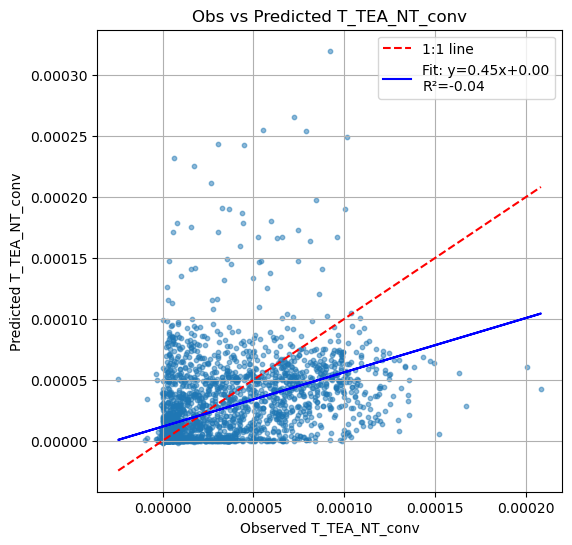

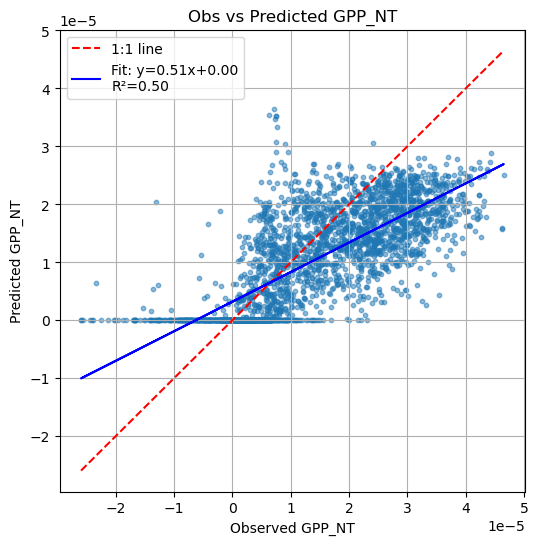

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Convert to dataframe
df2 = ds.to_dataframe().reset_index()

# --- T_TEA_NT_conv ---
x = df2["T_TEA_NT_conv"] * -1
y = df2["T_TEA_NT_conv_pred"] * -1

# Linear fit
m, b = np.polyfit(x, y, 1)
r2 = r2_score(x, y)

plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.5, s=10)
plt.plot([x.min(), x.max()], [x.min(), x.max()], color="red", linestyle="--", label="1:1 line")
plt.plot(x, m*x + b, color="blue", linestyle="-", label=f"Fit: y={m:.2f}x+{b:.2f}\nR²={r2:.2f}")
plt.xlabel("Observed T_TEA_NT_conv")
plt.ylabel("Predicted T_TEA_NT_conv")
plt.title("Obs vs Predicted T_TEA_NT_conv")
plt.legend()
plt.grid(True)
plt.show()

# --- GPP_NT ---
x = df2["GPP_NT"]
y = df2["GPP_NT_pred"]

m, b = np.polyfit(x, y, 1)
r2 = r2_score(x, y)

plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.5, s=10)
plt.plot([x.min(), x.max()], [x.min(), x.max()], color="red", linestyle="--", label="1:1 line")
plt.plot(x, m*x + b, color="blue", linestyle="-", label=f"Fit: y={m:.2f}x+{b:.2f}\nR²={r2:.2f}")
plt.xlabel("Observed GPP_NT")
plt.ylabel("Predicted GPP_NT")
plt.title("Obs vs Predicted GPP_NT")
plt.legend()
plt.grid(True)
plt.show()
